## Load data

In [63]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display
import matplotlib

plt.style.use('seaborn-v0_8-paper')
# matplotlib.rcParams.update({
#     'text.usetex': True
# })

Function to load the development or evaluation sets when asked.

In [64]:
def load_data(phase, path = os.getcwd()):
    if phase == "dev":
        data_path = os.path.join("dsl_data", "development.csv")
    elif phase == "eval":
        data_path = os.path.join("dsl_data", "evaluation.csv")
    else:
        raise Exception(f"Error - phase '{phase}' not recognised.")

    df = pd.read_csv(os.path.join(path, data_path))

    datas = []
    for wav_path in df["path"]:
        audio, _ = librosa.load(os.path.join(path, wav_path), res_type="kaiser_fast")
        datas.append(audio)
    df["data"] = datas

    if phase == "dev":
        df["intent"] = df["action"] + df["object"]
        df.drop(columns=["action", "object"], inplace=True)
    
    return df

In [65]:
SR = 22050
df_dev  = load_data("dev")
df_eval = load_data("eval")

## Exploratory data analysis

Exclusively for the preprocessing phase, we will concat the development and evaluation data set. In this way we can modify the variables only once and study the distribution of the data in more detail.

In [66]:
df = pd.concat([df_dev, df_eval], sort=False, ignore_index=True)
df_dev.shape, df_eval.shape, df.shape

((9854, 10), (1455, 9), (11309, 10))

In [67]:
mean_l = np.mean([len(x) for x in df["data"]])
mean_s = mean_l/SR
print(f"mean time of recordings: {mean_s}")

mean time of recordings: 2.591390919559382


We can hear what the audio says to gain some insight.

In [68]:
import IPython.display as ipd
ipd.Audio(df["path"][0])

Check for missing values, data types and number of unique values.

In [69]:
pd.DataFrame({"Type": df.dtypes, "NaN": df.isna().any(axis=0), "# unique": df[df.columns.drop("data")].nunique()})

,Type,NaN,# unique
Current language used for work/school,object,False,4.0
First Language spoken,object,False,5.0
Id,int64,False,9854.0
Self-reported fluency level,object,False,4.0
ageRange,object,False,3.0
data,object,False,NaN
gender,object,False,2.0
intent,object,True,7.0
path,object,False,11309.0
speakerId,object,False,97.0


Just `intent`, but it is because `df_eval` does not have the label column.

Let's do some plots to study the distributions of the variables.

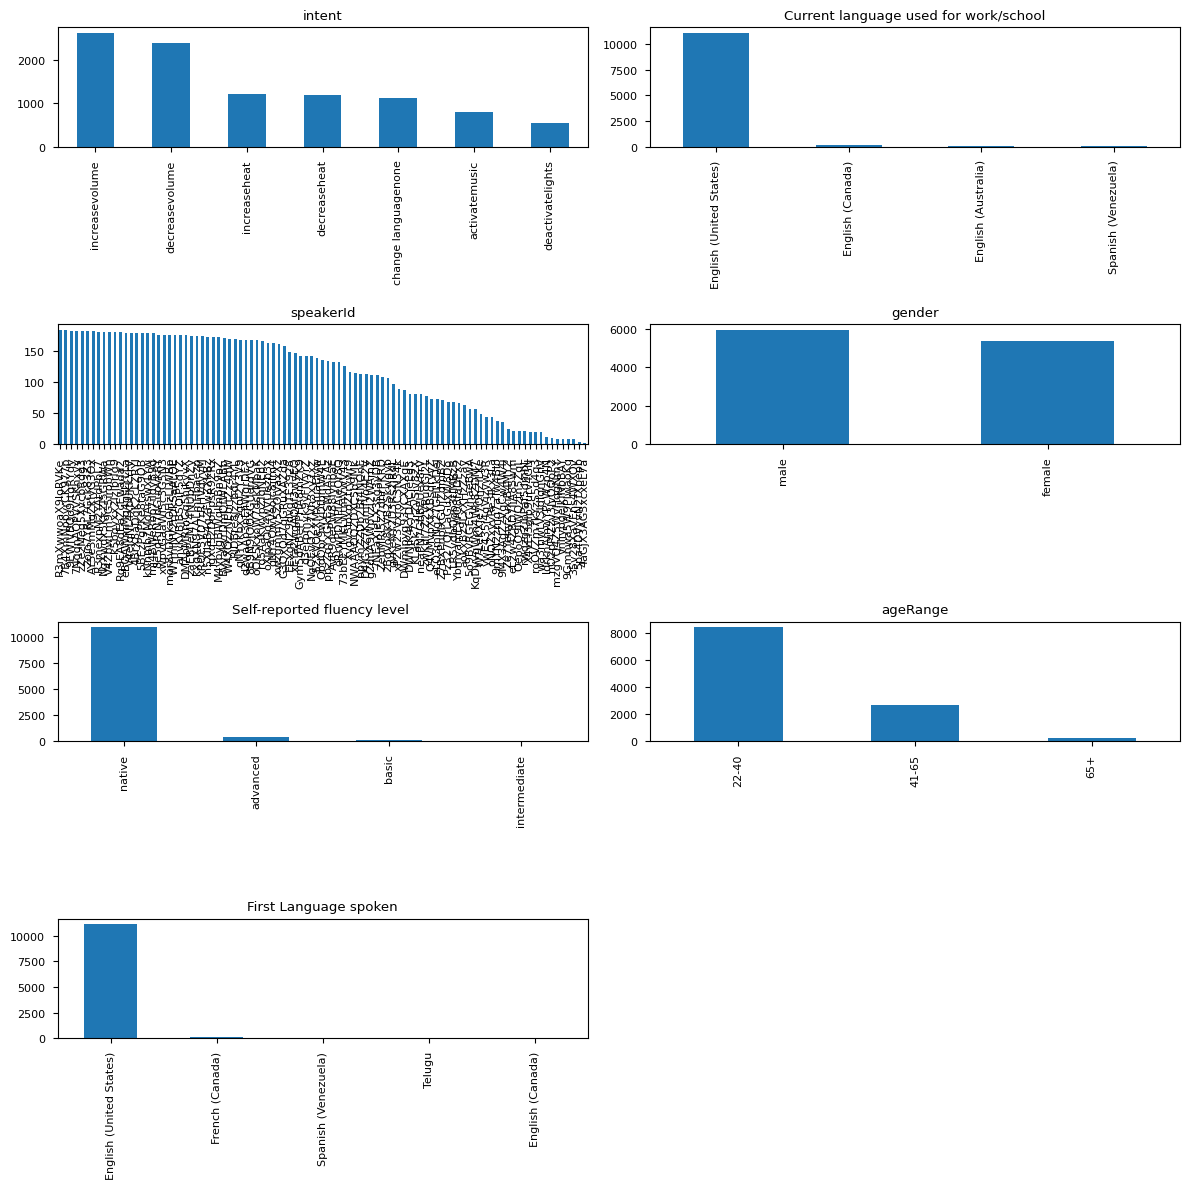

In [70]:
cols = ["intent", "speakerId", "Self-reported fluency level ", "First Language spoken", "Current language used for work/school", "gender", "ageRange"]
fig, ax = plt.subplots(4, 2, figsize=(12, 12))
for idx, c in enumerate(cols):
    if idx < 4:
        j = 0
    else:
        j = 1
    df[c].value_counts().plot.bar(ax=ax[idx%4][j])
    ax[idx%4][j].set_title(c)
plt.delaxes(ax[3, 1])
plt.tight_layout()
plt.show()

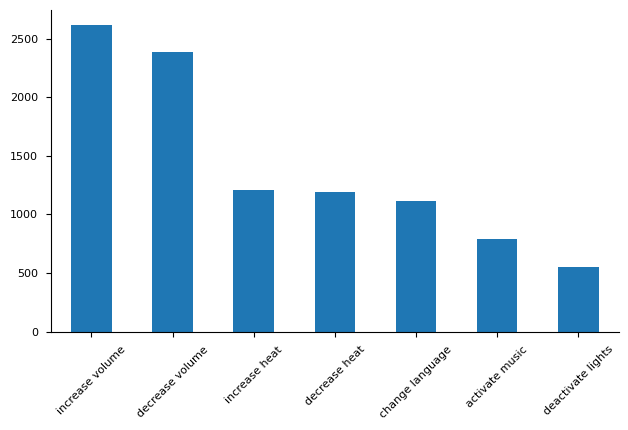

In [71]:
fig, ax = plt.subplots()
df["intent"].value_counts().plot.bar(ax=ax)
ax.set_xticklabels(["increase volume", "decrease volume", "increase heat", "decrease heat", "change language", "activate music", "deactivate lights"], rotation=45)
# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig('../report/figures/intent.svg')

Count the number of people the are not native english and that do not speak english (united states) during thei life.

In [72]:
idxs = (df["First Language spoken"] == 'English (United States)') * (df["Self-reported fluency level "] == 'native') * (df['Current language used for work/school'] == 'English (United States)')
perfect_speaker = idxs.sum()
print(f"There are {perfect_speaker} perfect speaker")

There are 10834 perfect speaker


Plot the distribution of `gender` and `ageRange` grouping by the `intent`.

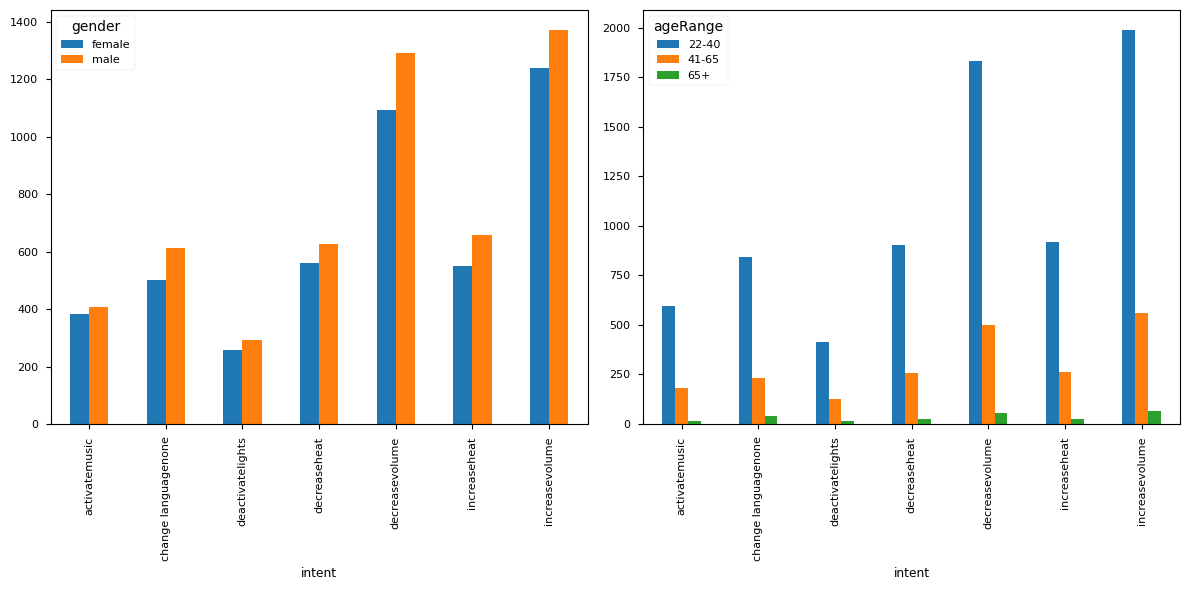

In [73]:
cols = ["gender", "ageRange"]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for i, c in enumerate(cols):
    table = pd.pivot_table(df, columns=[c], index=["intent"], values="Id", aggfunc="count")
    table.plot(kind = "bar", ax=ax[i])
plt.tight_layout()
plt.show()

## Preprocessing

Trim the data to cut off useless trailing and leading silences.

In [74]:
df["data"] = [librosa.effects.trim(data)[0] for data in df["data"]]

In [82]:
lenghts = [len(x) for x in df["data"]]
perc = 95
desired_length = int(np.ceil(np.percentile(lenghts, perc)))
l = [len(x)/SR for x in df["data"]]

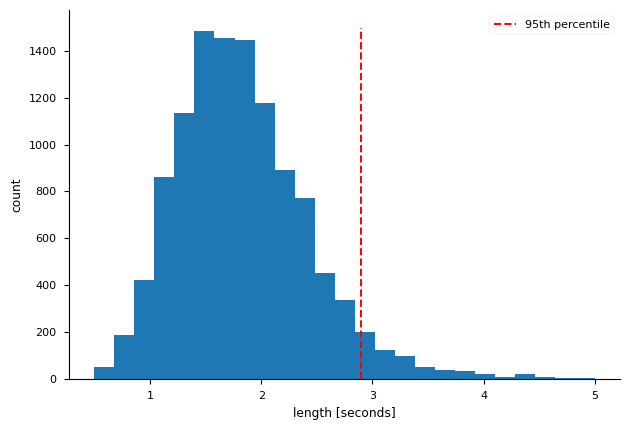

In [98]:
fig, ax = plt.subplots()
ax.hist(l, bins=25, range=(0.5, 5))
# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)
ax.vlines(x=[desired_length/SR], ymin=[0], ymax=[1500], colors='red', ls='--', label='95th percentile')
ax.set_xlabel("length [seconds]")
ax.set_ylabel("count")
plt.legend()
plt.tight_layout()
plt.savefig('../report/figures/perc.svg')

In [12]:
mean_l = np.mean([len(x) for x in df["data"]])
mean_s = mean_l/SR
print(f"mean time of recordings: {mean_s}")

mean time of recordings: 1.8342654306394943


Now let's plot the amplitude of the audio to see how they are made.

In [13]:
def plot_audio_samples(datas, ax):
    for idx in range(0, len(datas), 1000):
        librosa.display.waveshow(datas[idx], alpha=0.5, ax=ax)

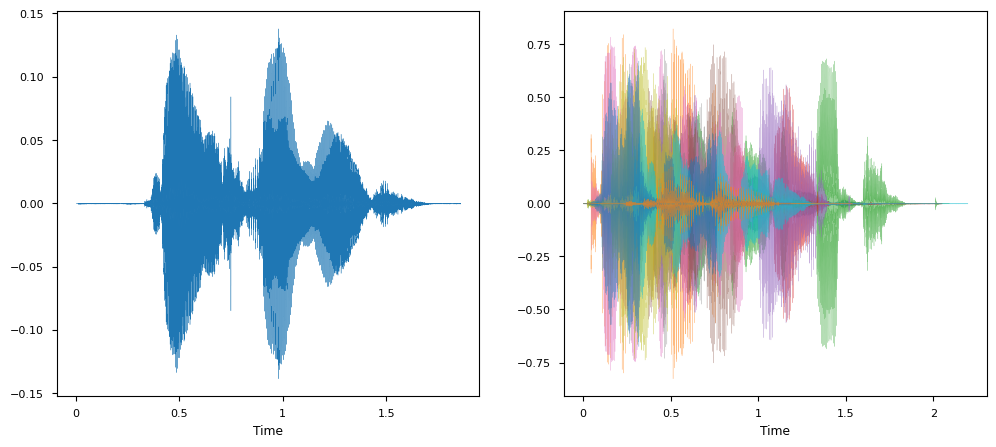

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
librosa.display.waveshow(df["data"][0], ax=ax[0])
plot_audio_samples(df["data"], ax=ax[1])

We should pad and cut to have the same length for each audio. So we get the same number of features for each sample.    
First, we cut; then we add padding at the end in order to have equal lenght.
We add some  zeros, which represent silence.

In [15]:
lengths = [len(data) for data in df["data"]]
perc = 95
desired_length = int(np.ceil(np.percentile(lengths, perc)))
print(f"{desired_length = }")

df["data"] = [data[:desired_length] for data in df["data"]]
df["data"] = [np.pad(data, (0,desired_length-len(data)), constant_values=0.0) for data in df["data"]]

desired_length = 63974


In [16]:
desired_s = desired_length/SR
print(f"duration of the recordings after pad and cut: {desired_s}")

duration of the recordings after pad and cut: 2.9013151927437644


## Feature extraction

Let's extract the Mel-frequency cepstral coefficients (MFCCs) using the `librosa.feature.mfcc()` function.

In [17]:
from sklearn.preprocessing import StandardScaler
# number of mfccs to extract
n_mfcc = 10 
scaler = StandardScaler() #to normalize mfcc
mfccs = [librosa.feature.mfcc(y=data, n_mfcc = n_mfcc).T for data in df["data"]]
mfccs = [scaler.fit_transform(mfcc) for mfcc in mfccs]
mfccs[0].shape

(125, 12)

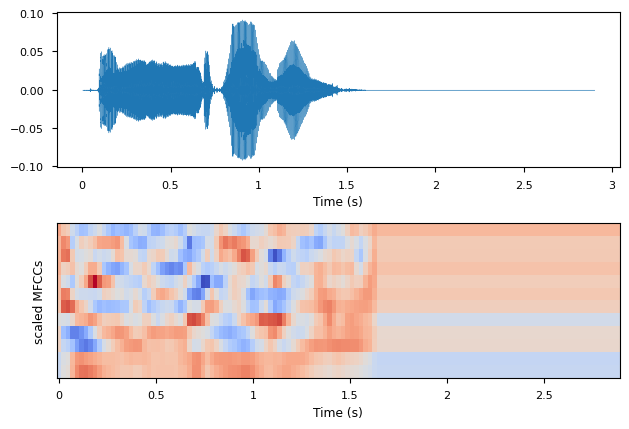

In [56]:
fig1, ax = plt.subplots(2, 1)
librosa.display.waveshow(df["data"][21], x_axis='s', ax=ax[0])
librosa.display.specshow(mfccs[21].T, x_axis='s', ax=ax[1])
ax[1].set_ylabel("scaled MFCCs")
plt.tight_layout()
plt.savefig('../report/figures/mfcc.svg')

## Classification

### useful function for classification

Since the shapes are all big matrices, we could get some statistical measures from each $n \times m$ box. In particular we have chosen
- mean
- standard deviation
- minimum
- maximum

In [21]:
def compute_statistical_features(matrix, n = 4, m = 10):
    feat = []
    N, M = matrix.shape
    for i in range(0, N, n):
        for j in range(0, M, m):
            feat.append(np.array([
                np.mean(matrix[i:i+n, j:j+m]),
                np.std(matrix[i:i+n, j:j+m])
                # np.min(matrix[i:i+n, j:j+m]),
                # np.max(matrix[i:i+n, j:j+m])
                ]))
    return np.hstack(feat)

function to test the various model in order to make life easier.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsOneClassifier

def test_model(model, params, X, y, cv=5, scale=False, pca=False, n_components=100, ovo=False):
    pip = []
    # Scale the data if necessary
    if scale:
        pip.append(("scale", StandardScaler()))
    # Perform PCA if necessary
    if pca:
        pip.append(("pca", PCA(n_components=100)))
    # Create a grid search object
    pip.append(("clf", model))
    clf = Pipeline(pip)
    if ovo:
        clf = OneVsOneClassifier(clf, n_jobs=-1)
        params = {("estimator__clf__"+key): value for (key, value) in params.items()}
    else:
        params = {("clf__"+key): value for (key, value) in params.items()}
    gs = GridSearchCV(clf, params, cv=cv, scoring="accuracy")
    # Fit the model
    gs.fit(X, y)
    return gs

function to write the output file

In [23]:
def write_output(df, model, X_eval):
    eval_mask = df["intent"].isna()
    y_pred = model.predict(X_eval)
    pd.DataFrame(y_pred, index=df["Id"][eval_mask]).to_csv("output.csv", index_label="Id", header=["Predicted"])

function that tries the pca and shows (if required by `out=True`) the variance explained by it.     
By default, it return the 85th, 90th, 95th percentiles.

In [24]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def try_pca(X, qs = [0.85, 0.90, 0.95], out=False):
    pre = make_pipeline(
        StandardScaler(),
        PCA()
    )
    pca_df_scaled = pre.fit_transform(X)
    evr = pre["pca"].explained_variance_ratio_
    if out:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].bar(range(1,len(evr)+1), evr)
        ax[0].set_xlabel("Principal components")
        ax[0].set_ylabel("Explained variance ratio")
        ax[1].plot(range(1,len(evr)+1), evr.cumsum(), marker="o")
        ax[1].set_xlabel("Principal components")
        ax[1].set_ylabel("Cumulative explained variance ratio")
        ax[1].set_yticks(np.arange(0, 1.1, 0.1))
        plt.tight_layout()
        plt.show()

    zs = []
    for q in qs:
        z = next(x[0] for x in enumerate(evr.cumsum()) if x[1] > q)
        if out:
            print(f"The {q}% of the data has length lower or equal to {z}.")
        zs.append(z)
    
    return zs

function that builds the dataset with the features we require and the columns of the dataset we want.       
`nonnative` is used to select wheter or not we want the non english speaker in the development dataset.

In [25]:
from sklearn.model_selection import train_test_split

def build_datasets(df, feats, cols_to_keep=[], compute_stats=[False], n=8, m=10, nonnative=True):
    features = []
    for i, f in enumerate(feats):
        if compute_stats[i]:
            features.append(np.vstack([compute_statistical_features(x, n, m) for x in f]))
        else:
            features.append(np.vstack([np.ravel(x) for x in f]))
    features = np.hstack(features)
    if cols_to_keep:
        df_1h = pd.get_dummies(df[cols_to_keep], columns=cols_to_keep)
        X = np.hstack([df_1h.values, features])
    else:
        X = features
    eval_mask = df["intent"].isna()
    if nonnative == False:
        idxs = (df["First Language spoken"] == 'English (United States)') * (df["Self-reported fluency level "] == 'native') * (df['Current language used for work/school'] == 'English (United States)')
        dev_mask = ~eval_mask * idxs
    else:
        dev_mask = ~eval_mask
    X_dev = X[dev_mask]
    X_eval = X[eval_mask]
    y = df["intent"][dev_mask]
    
    return X_dev, y, X_eval

### Support vector machine

In [26]:
X_dev, y, X_eval = build_datasets(df, feats=[mfccs], compute_stats=[False], cols_to_keep=["ageRange", "gender"])
X_dev.shape, y.shape, X_eval.shape

((9854, 1505), (9854,), (1455, 1505))

In [27]:
z = try_pca(X_dev)
z

[202, 272, 399]

In [28]:
from sklearn.svm import SVC

svm_params = {
    "kernel": ['rbf'],
    "C": [10]
} 

gs = test_model(SVC(), svm_params, X_dev, y, pca=True, n_components=z[1], ovo=True)
print(f"""
    {gs.best_params_ = }
    {gs.best_score_ = }
""")
write_output(df, gs, X_eval)


    gs.best_params_ = {'estimator__clf__C': 10, 'estimator__clf__kernel': 'rbf'}
    gs.best_score_ = 0.6393279198118917



### Random forest classifier

In [30]:
X_dev, y, X_eval = build_datasets(df, feats=[mfccs], compute_stats=[False])
X_dev.shape, y.shape, X_eval.shape

((9854, 1500), (9854,), (1455, 1500))

In [31]:
z = try_pca(X_dev)
z

[200, 270, 397]

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_params = {
    "max_depth": [20],
    "n_estimators": [100],
    "criterion": ["gini"],
    "n_jobs" : [-1],
    "random_state":[1]
}

gs = test_model(RandomForestClassifier(), forest_params, X_dev, y, pca=True, n_components=z[1])
print(f"""
    {gs.best_params_ = }
    {gs.best_score_ = }
""")
write_output(df, gs, X_eval)


    gs.best_params_ = {'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__n_estimators': 100, 'clf__n_jobs': -1, 'clf__random_state': 1}
    gs.best_score_ = 0.37395761382688575



### KNN

In [54]:
X_dev, y, X_eval = build_datasets(df, feats=[mfccs], compute_stats=[False], cols_to_keep=["gender", "ageRange"])
X_dev.shape, y.shape, X_eval.shape

((9854, 1505), (9854,), (1455, 1505))

In [55]:
z = try_pca(X_dev)
z

[202, 272, 399]

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    "n_neighbors": [5, 6, 7],
    'weights': ['distance']
}

gs = test_model(KNeighborsClassifier(), knn_params, X_dev, y, pca=True, n_components=z[1])
print(f"""
    {gs.best_params_ = }
    {gs.best_score_ = }
""")
write_output(df, gs, X_eval)


    gs.best_params_ = {'clf__n_neighbors': 5, 'clf__weights': 'distance'}
    gs.best_score_ = 0.666910248756219

